Install Dependencies:
run "pip install -r requirements.txt" in the console

In [1]:
#import libraries
from obspy import read
import numpy as np
import matplotlib.pyplot as plt

The following line reads the example sgy data file

This data is from the Netherlands, Coordinates: N 54° 52’ 0.86” / E 4° 48’ 47.07”

https://terranubis.com/datainfo/F3-Demo-2020

In [2]:
st = read('./data/Seismic_data.sgy', format='SEGY')

In [3]:
inline_length = max(trace.stats.segy.trace_header.trace_sequence_number_within_line for trace in st)
crossline_length = len(st) // (inline_length + 1)
sample_depth_length = len(st[0].data)

print("Inline Length:", inline_length)
print("Crossline Length:", crossline_length)
print("Sample depth length:", sample_depth_length)

Inline Length: 951
Crossline Length: 630
Sample depth length: 462


In [4]:
seismic_3d_array = np.zeros((inline_length + 1, crossline_length + 1, sample_depth_length))

# Populate the 3D array
for i, trace in enumerate(st):
    inline = trace.stats.segy.trace_header.trace_sequence_number_within_line
    crossline = i % (crossline_length + 1)  # Calculate crossline dynamically based on iteration
    seismic_3d_array[inline, crossline, :] = trace.data

In [5]:
#converted to 3d array for easier processing
print(seismic_3d_array.shape)

(952, 631, 462)


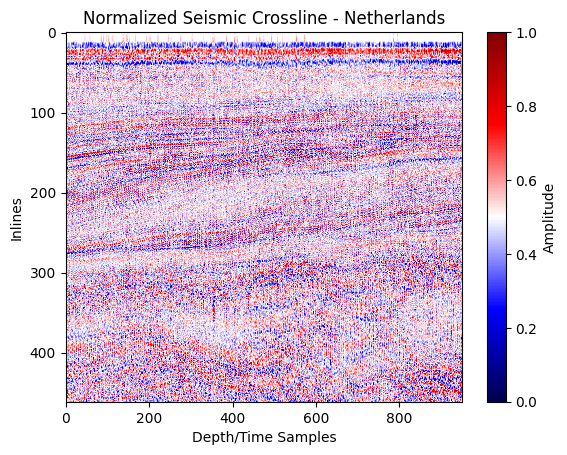

In [36]:

clip_threshold = 5000


normalized_data = np.clip(seismic_3d_array[:, 0, :], a_min=-clip_threshold, a_max=clip_threshold)

normalized_data = (normalized_data-np.amin(normalized_data))/abs(np.amax(normalized_data)-np.amin(normalized_data))


seismic_image = np.flipud(np.rot90(normalized_data))

# Plot the normalized crossline
plt.imshow(seismic_image, cmap='seismic', aspect='auto')
plt.colorbar(label='Amplitude')
plt.title('Normalized Seismic Crossline - Netherlands')
plt.xlabel('Depth/Time Samples')
plt.ylabel('Inlines')
plt.show()

In [37]:
import torch.nn as nn
import torch.nn.functional as F
import torch



class SeismicInterpreter(nn.Module):
    def __init__(self):
        super().__init__()
        #Encoding layers
        self.enc_conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_conv3 = nn.Conv2d(128, 256, 3, padding=1)

        self.dec_conv1 = nn.Conv2d(256, 128, 3, padding=1)
        self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):
        #Encoder
        x1 = F.relu(self.enc_conv1(x))
        x2 = F.relu(self.enc_conv2(x1))
        x3 = F.relu(self.enc_conv3(x2))
        
        # Decoder
        x4 = F.relu(self.dec_conv1(x3))
        x5 = F.relu(self.dec_conv2(x4))
        x6 = self.dec_conv3(x5)
        
        return x6


In [38]:
print("Cuda available: " + str(torch.cuda.is_available()))

Cuda available: False


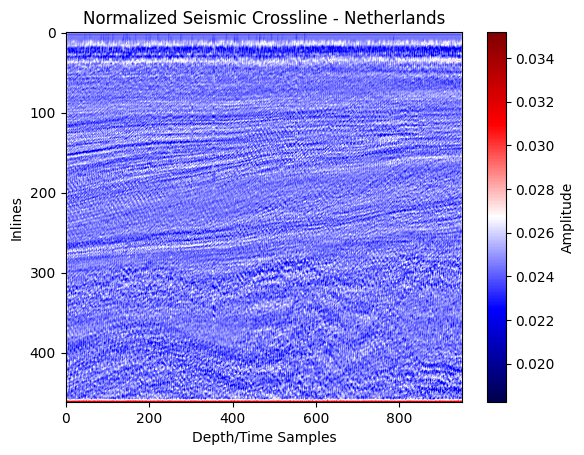

In [40]:

model = SeismicInterpreter()


input_image = torch.from_numpy(seismic_image).float()

with torch.no_grad():
    output_image = model(input_image.unsqueeze(0))

plt.imshow(output_image[0], cmap='seismic', aspect='auto')
plt.colorbar(label='Amplitude')
plt.title('Normalized Seismic Crossline - Netherlands')
plt.xlabel('Depth/Time Samples')
plt.ylabel('Inlines')
plt.show()



loss = nn.CrossEntropyLoss()

for epoch in range(50):
    pass
